In [1]:
install.packages("readxl")
library("readxl")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
install.packages('xlsx')
library('xlsx')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
data <- read_excel("data.xlsx", sheet = "data", col_names=TRUE)
column_names <- c('X1', 'X2', 'X3', 'X4', 'X6', 'X8')
my_data <- data[column_names]

In [4]:
qq_plot <- function(x) {
  qqnorm(x)
  qqline(x, col = "steelblue", lwd = 2)
}

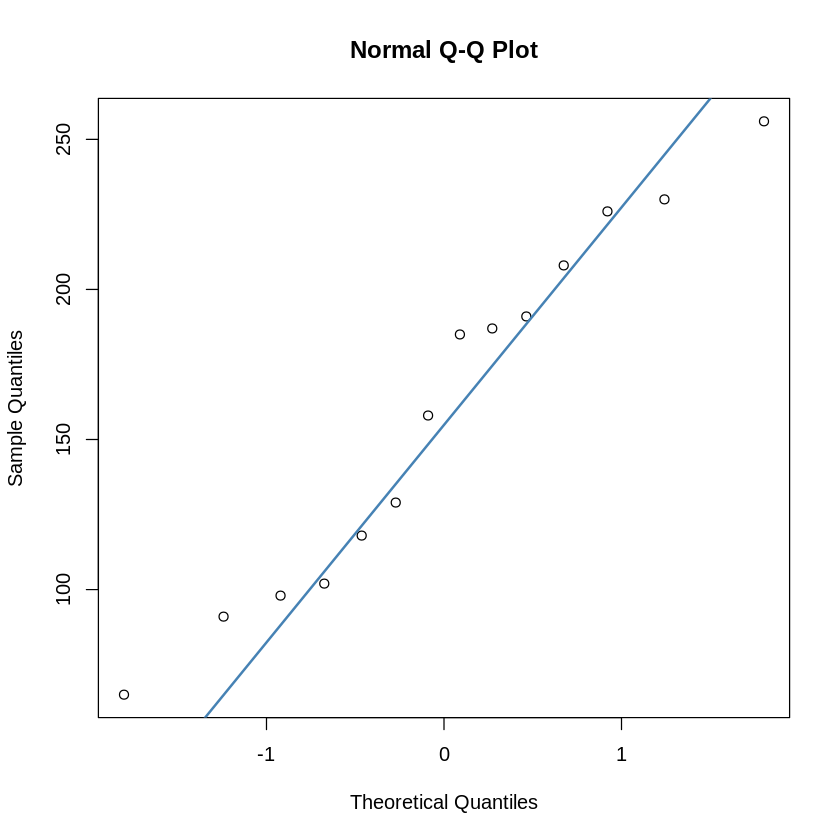

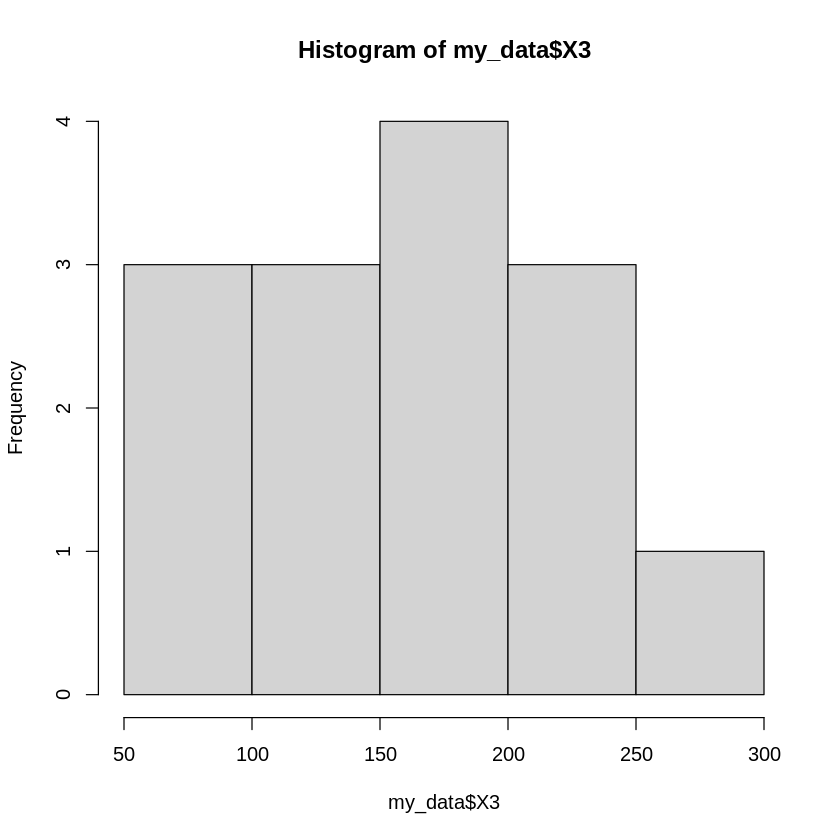

In [5]:
qq_plot(my_data$X3)
hist(my_data$X3)

In [6]:
# создание бутстреп-выборки объемом n средних значений из исходной выборки x
bt_means <- function(x, n) {
  print('Среднее значение')
  print(mean(x))
  print('Коэффициент вариации')
  print(sd(x)/mean(x))
  bt <- numeric(n)
  for (i in 1:n)
    bt[i] <- mean(sample(x, replace=T))
  return(bt)
}

In [7]:
# запись результатов реализации метода бутстреп в файл формата .csv
export_df <- bt_means(my_data$X1, 1000)
write.csv(export_df, './export_data.csv')

[1] "Среднее значение"
[1] 14.21429
[1] "Коэффициент вариации"
[1] 1.017093


In [8]:
# запись полученных ранее результатов реализации метода бутстреп в файл формата .xlsx
write.xlsx(export_df, './export_excel_file.xlsx', sheetName='export_data')

In [9]:
# функция оценки доверительных интервалов методом процентилей с 95% доверительной вероятностью
procentile_CI <- function(result) {
  print('Procentile method')
  print(round(quantile(result, 0.025), 3))
  print(round(quantile(result, 0.975), 3))
}

In [10]:
# функция оценки доверительных интервалов методом основных интервалов  с 95% доверительной вероятностью
basic_CI <- function(result) {
  print('Basic CI method')
  print(round(2*mean(result) - quantile(result, 0.975), 3))
  print(round(2*mean(result) - quantile(result, 0.025), 3))
}

In [11]:
# функция оценки доверительных интервалов с использованием t-критерия
t_statistic_CI <- function(result, x) {
  print('t-statistic method')
  print('2.5%')
  print(round(mean(result) - qt(0.975, length(x)-1)*sqrt(var(result)), 3))
  print('97.5%')
  print(round(mean(result) + qt(0.975, length(x)-1)*sqrt(var(result)), 3))
}

In [12]:
# функция расчета доверительных интервалов по вышеобозначенным методам для выборки x
output_set <- function(x) {
  print('--------------')
  set.seed(5)
  result <- bt_means(x, 10000)
  procentile_CI(result)
  basic_CI(result)
  t_statistic_CI(result, x)
}

In [13]:
# расчет доверительных интервалов для конкретного показателя из набора данных
# например my_data$X1 - Отправлено грузов железнодорожным транспортом, млн. т.
output_set(my_data$X1)

[1] "--------------"
[1] "Среднее значение"
[1] 14.21429
[1] "Коэффициент вариации"
[1] 1.017093
[1] "Procentile method"
 2.5% 
7.343 
 97.5% 
22.179 
[1] "Basic CI method"
97.5% 
6.271 
  2.5% 
21.108 
[1] "t-statistic method"
[1] "2.5%"
[1] 6.113
[1] "97.5%"
[1] 22.337


In [14]:
# расчет доверительных интервалов для всего набора исходных данных
# есть трудности с обозначением конкретных показателей
# в силу асинхронности операций
# print(apply(my_data, 2, output_set))

In [15]:
# функция расчета t-статистики
t.stat <- function(n1, n2, vec1, vec2) {
  moy1 <- mean(vec1)
  moy2 <- mean(vec2)
  var1 <- var(vec1)
  var2 <- var(vec2)
  var.wm <- ((n1 - 1)*var1 + (n2 - 1)*var2) / (n1 + n2 - 2)
  t <- (moy1 - moy2) / sqrt(var.wm * ((1/n1) + (1/n2)))
  return(list(moy1=moy1, moy2=moy2, var1=var1, var2=var2, stat=t))
}

In [16]:
# функция статистики Стьюдента для двух выборок
comp_stat <- function(v1, v2, method=1) {
  if (method == 1) st <- t.stat(length(v1), length(v2), v1, v2)$stat # Статистика Стьюдента
  if (method == 2) st <- sum(v1) - sum(v2) # Разность сумм
  if (method == 3) st <- median(v1) - median(v2) # Разность медиан
  if (method == 4) st <- mean(v1)/mean(v2) # Отношение средних
  return(st)
}

In [17]:
# функция рандомизационного теста
RandRes <- function (emp, sim, Nrand = 999, w.plot = 0) { 
# Параметры: 
# emp - эмпирическое значение 
# sim - вектор рандомизированных значений
# Nrand - число итераций рандомизации
# w.plot <> 0  - выводится окно с гистограммой
# Подготовка таблицы для вывода результатов рандомизации
CI <-  as.matrix(rep(NA, 7)) ; ; colnames(CI) <- "Стат"
rownames(CI) <- c("Эмпир.знач.","Средн.Ранд","CIлев", "CIправ", "Р(ранд>эмп)","Р(ранд<эмп)","Р(|ранд|>|эмп|)")
  CI[1] <-  emp ;   CI[2] <- mean(sim)
#    Доверительные интервалы методом процентилей
  CI[3] <- quantile(sim, prob=0.025) ;   CI[4] <- quantile(sim, prob=0.975)
#   Проверка односторонних гипотез
CI[5] <- (sum(sim >= emp)+1) / (Nrand + 1) ; CI[6]  <- (sum(sim <= emp)+1) / (Nrand + 1) 
#   Проверка двухсторонней гипотезы
CI[7]   <- (sum(abs(sim)- abs(emp) >= 0)+1) / (Nrand + 1) 
#   Расчет доверительных интервалов
CI.l <- quantile(sim, prob=0.025) ; CI.u <- quantile(sim, prob=0.925) 
# Вывод гистограммы при необходимости
if (w.plot == 1)  { plot(hist(sim), col="gray80") ; abline(v= emp, lty=3,col=2,lwd=2) }
return(t(CI))}

In [18]:
# функция выполнения рандомизационного теста заданной статистики n раз
sim_stat <- function(vec1, vec2, permutations=5000, method=1) {
  empar <- comp_stat(vec1, vec2, method)
  boots <- numeric(permutations)
  vec <- c(vec1, vec2)
  hist(vec)
  n1 <- length(vec1)
  n2 <- length(vec2)
  n <- n1 + n2
  for (i in 1:permutations) {
    vec.perm <- sample(vec, n)
    vec1.perm <- vec.perm[1:n1]
    vec2.perm <- vec.perm[(n1+1):n]
    boots[i] <- comp_stat(vec1.perm, vec2.perm)
  }
  return(RandRes(empar, boots, permutations))
}

,Эмпир.знач.,Средн.Ранд,CIлев,CIправ,Р(ранд>эмп),Р(ранд<эмп),Р(|ранд|>|эмп|)
Стат,0.6370038,-0.002810608,-1.980734,2.033079,0.2611478,0.7390522,0.5236953


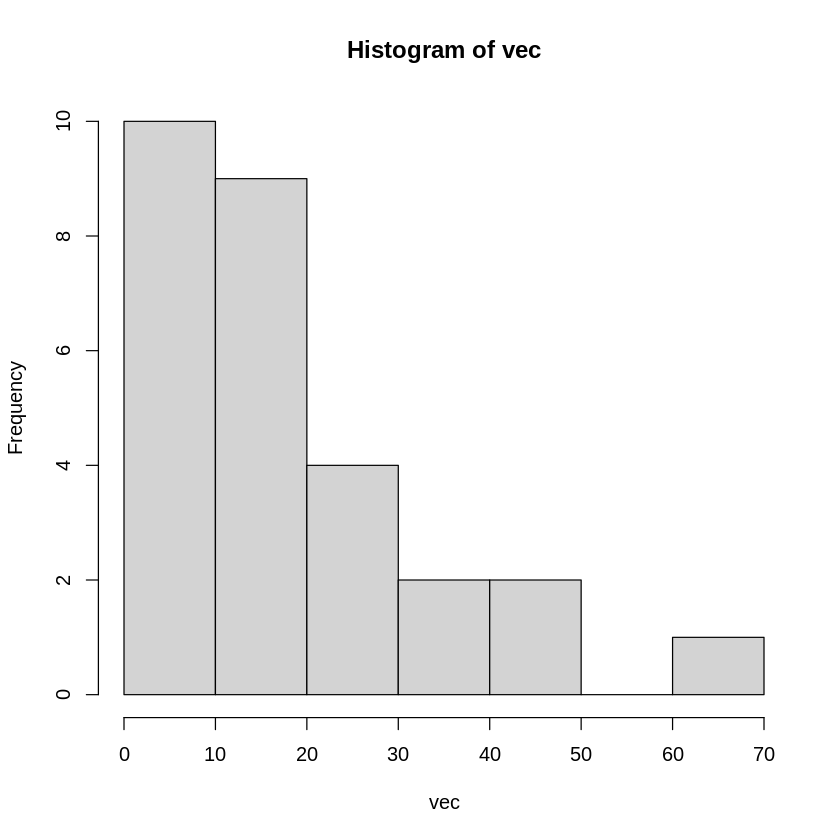

In [19]:
# сравнение выборок отправления грузов ж/д транспортом (Х1) и перевозок грузов автомобильным транспортом (Х4)
sim_stat(my_data$X1, my_data$X4, 5000, 4)

,Эмпир.знач.,Средн.Ранд,CIлев,CIправ,Р(ранд>эмп),Р(ранд<эмп),Р(|ранд|>|эмп|)
Стат,28.65896,-0.008122045,-2.004176,1.959561,0.00019996,1,0.00019996


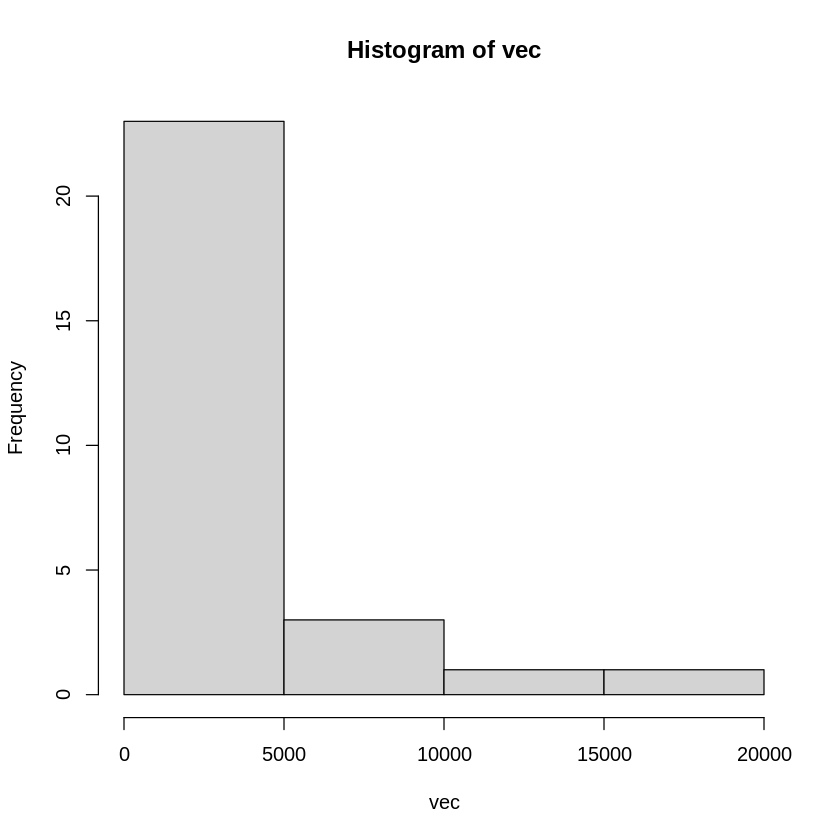

In [20]:
# сравнение выборок отправления пассажиров ж/д транспортом (Х2) и перевозок пассажиров автомобильным транспортом (Х6)
sim_stat(my_data$X2, my_data$X6, 5000, 4)

,Эмпир.знач.,Средн.Ранд,CIлев,CIправ,Р(ранд>эмп),Р(ранд<эмп),Р(|ранд|>|эмп|)
Стат,0.6020928,-0.0008594853,-2.061288,2.037676,0.2745451,0.7256549,0.55009


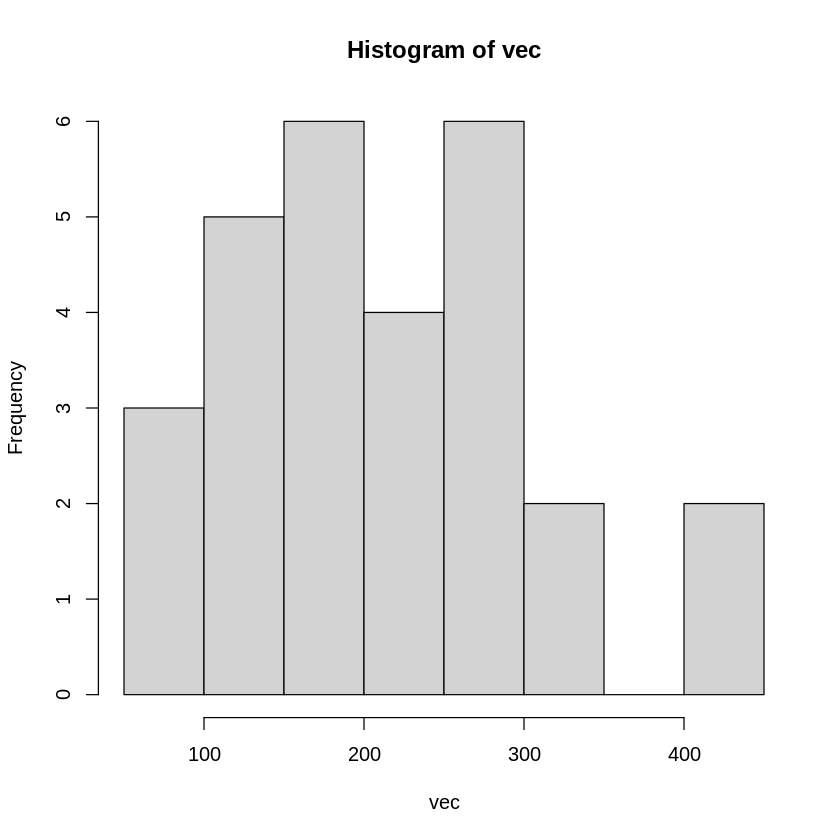

In [21]:
# сравнение выборок плотности ж/д путей (Х3) и автомобильных дорог общего пользования с твердым покрытием (Х8)
sim_stat(my_data$X3, my_data$X8, 5000, 4)